# PIR: 1st Autoregressive test

## 1: Imports

In [1]:
import utils # Fichiers contenant nos fonctions
import AR_models
import modelsV2

import importlib
import tensorflow as tf

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2026-01-13 21:37:46.364788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 21:37:46.414894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 21:37:48.770663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Désactive le GPU pour TensorFlow

In [3]:
# In case of 'utils.py' modifications
importlib.reload(utils)

<module 'utils' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/utils.py'>

In [51]:
# In case of 'modelsV2.py' modifications
importlib.reload(modelsV2)

<module 'modelsV2' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/modelsV2.py'>

In [61]:
# In case of 'AR_models.py' modifications
importlib.reload(AR_models)

<module 'AR_models' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/AR_models.py'>

## 2: Load + Data preparation

In [6]:
# Load the data
x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')

In [7]:
# Create the train and test dictionnaries
# TRAIN = before 2022-06-01
# TEST = after 2022-06-01
df_established_train, df_established_test = utils.prepare_backtest_data(x_train, y_train, remove_covid = True)

### 3.1: Sampling

In [38]:
sample_size = 8
seed = 463

sample_train = utils.sample_stations(df_established_train, sample_size, seed)
print("sample_train_keys() ", sample_train.keys())

sample_test = {
    station: df_established_test[station]
    for station in sample_train.keys()
}

print("sample_test_keys() ", sample_test.keys())

sample_train_keys()  dict_keys(['V6N', 'K5Q', '5PK', 'KY6', 'B61', 'P8U', 'NEB', '48S'])
sample_test_keys()  dict_keys(['V6N', 'K5Q', '5PK', 'KY6', 'B61', 'P8U', 'NEB', '48S'])


In [39]:
sample_test_true = {
    station: df_established_test[station].copy()
    for station in sample_test.keys()
}

### 3.3 Predictions

In [67]:
# Optimized Parameters
seq_len = 100
units = 32
activation = 'linear'
learning_rate = 0.009866
batch_size = 32

# Epochs
epochs = 20

In [68]:
sample_test_AR, mape_results_AR, all_losses_AR = AR_models.lstm_backtest_autoregressive(sample_train, sample_test, sample_test_true,
                                 seq_len, units, activation, learning_rate, batch_size,
                                 epochs, features=['y', 'job', 'ferie', 'vacances'])

[1/8] Station: V6N
[2/8] Station: K5Q
[3/8] Station: 5PK
[4/8] Station: KY6
[5/8] Station: B61
[6/8] Station: P8U
[7/8] Station: NEB
[8/8] Station: 48S


In [31]:
# sample_test_V2, mape_results_V2, all_losses_V2 = modelsV2.lstm_model(sample_train, sample_test, sample_test_true, sample_size, seq_len, units, activation, learning_rate, batch_size, epochs, early_stop = True, features = ['job', 'ferie', 'vacances'])

In [63]:
from keras.callbacks import EarlyStopping, TensorBoard # <--- Ajout de TensorBoard ici

### 3.3: Results

In [69]:
# Display MAPE results
utils.show_mape_results(mape_results_AR)

MAPE per station:
  station       MAPE
0     V6N   0.315884
1     K5Q   0.521929
2     5PK  16.195623
3     KY6   0.903726
4     B61   0.332020
5     P8U   0.295177
6     NEB   0.967475
7     48S   0.509835

Average MAPE over all stations: 2.5052


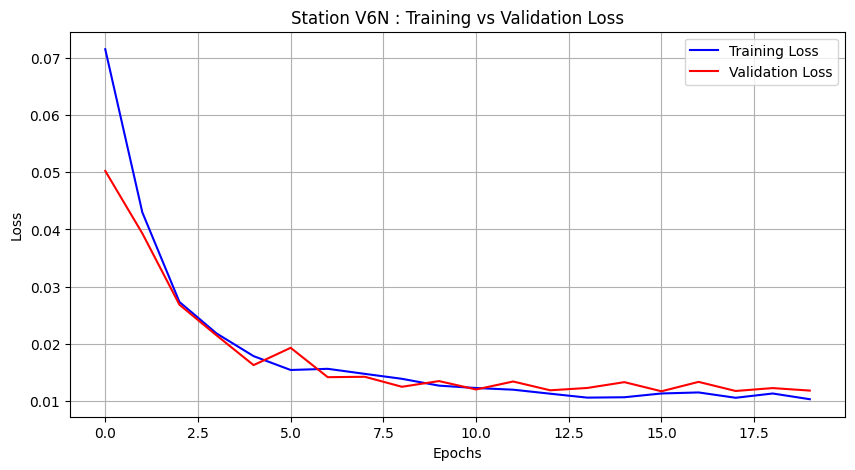

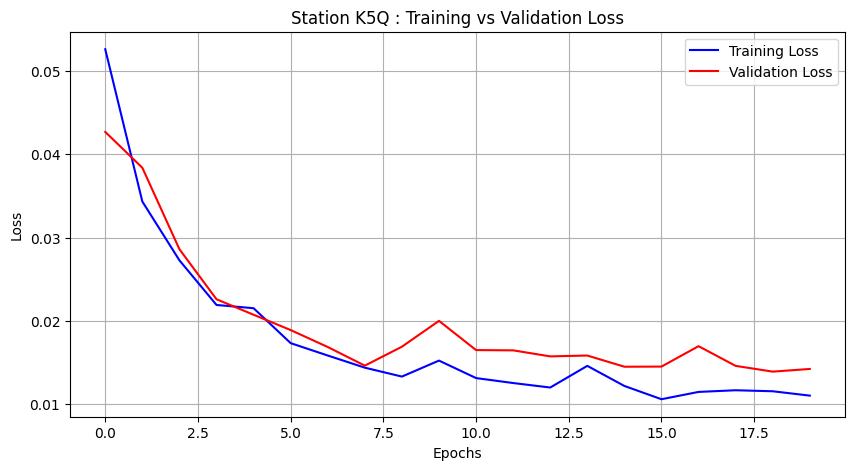

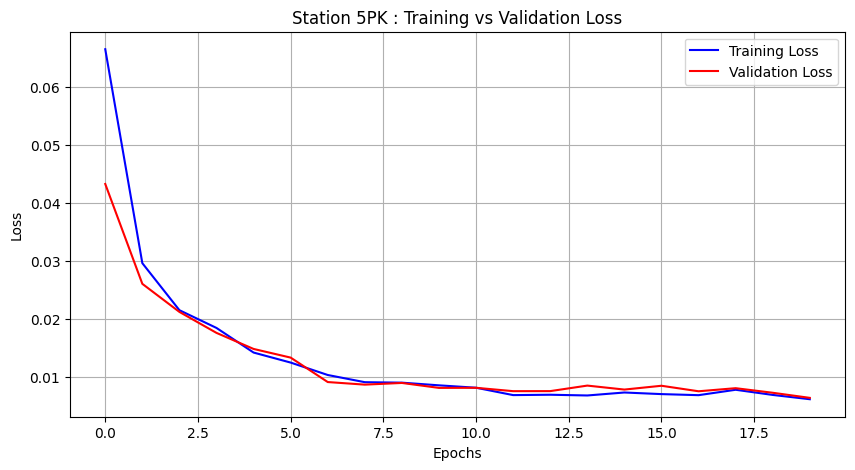

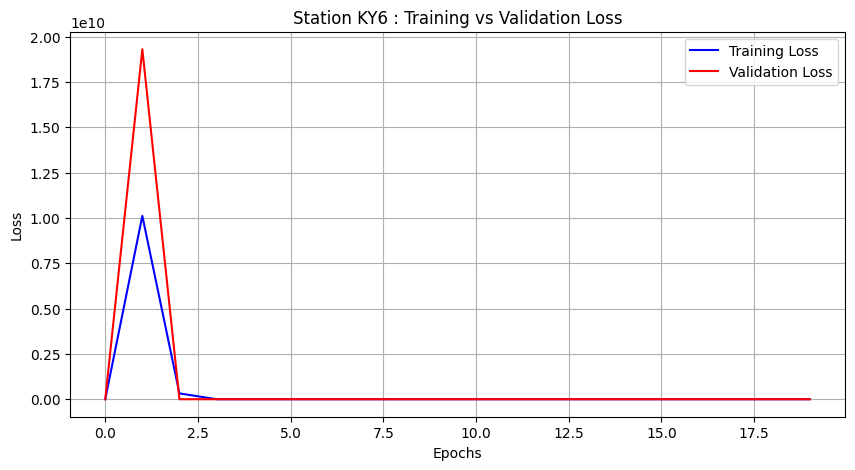

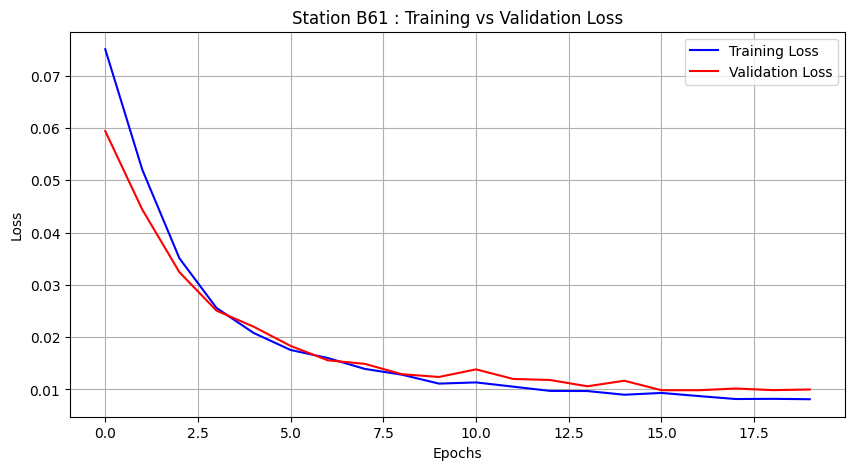

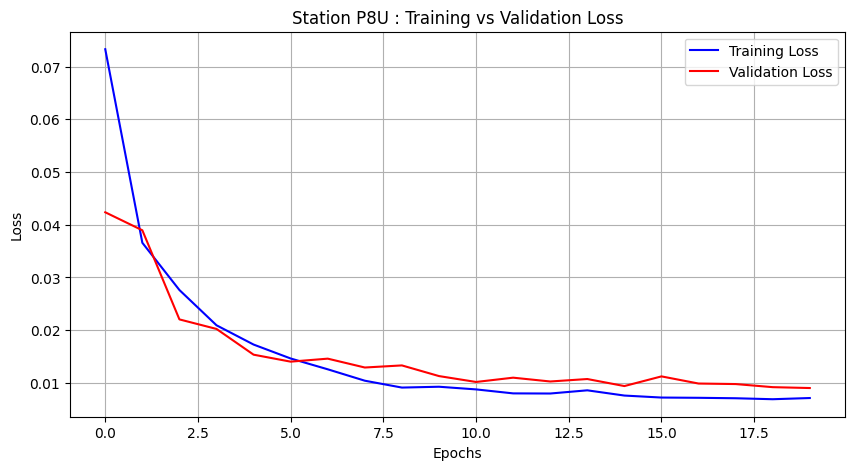

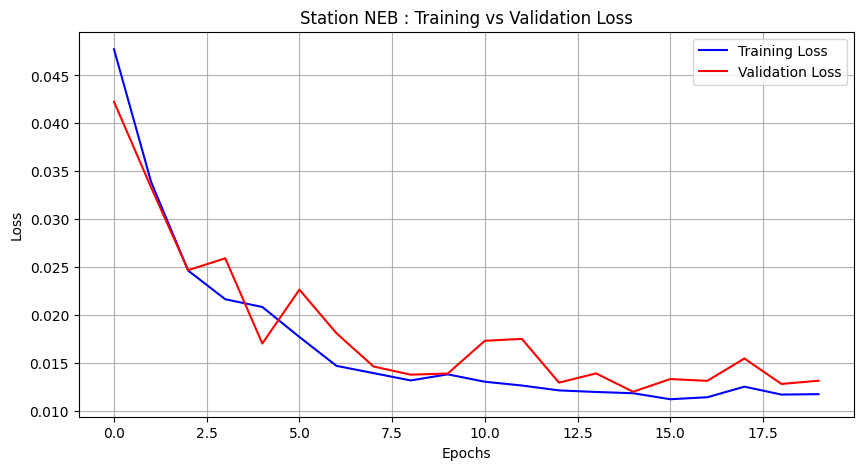

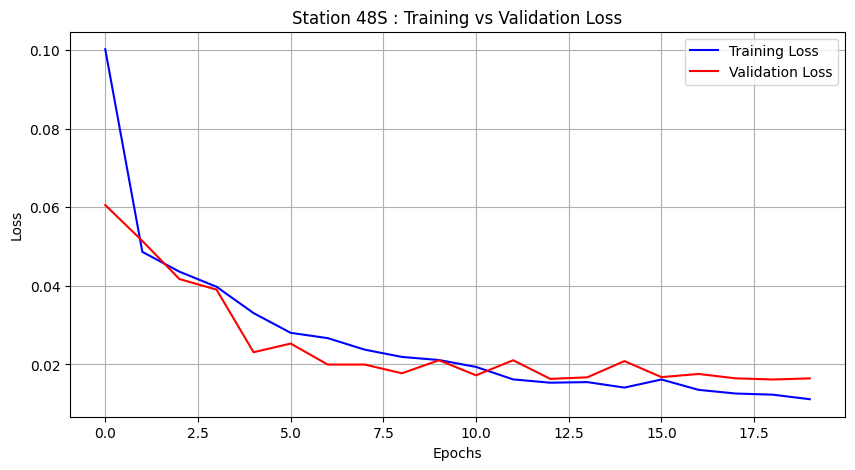

In [70]:
# Display losses for the sample
for station_name, history in all_losses_AR.items():
    utils.plot_training_loss(
        history['loss'], 
        history['val_loss'], 
        title=f"Station {station_name} : Training vs Validation Loss"
    )

In [ ]:
# Display MAPE results
utils.show_mape_results(mape_results_V2)

MAPE per station:
  station      MAPE
0     DF2  0.271367
1     CSD  4.034691
2     AOW  2.062959
3     XOK  0.920971
4     WIX  0.996656
5     GMD  0.219599
6     12Q  0.845065
7     ICH  0.305622

Average MAPE over all stations: 1.2071


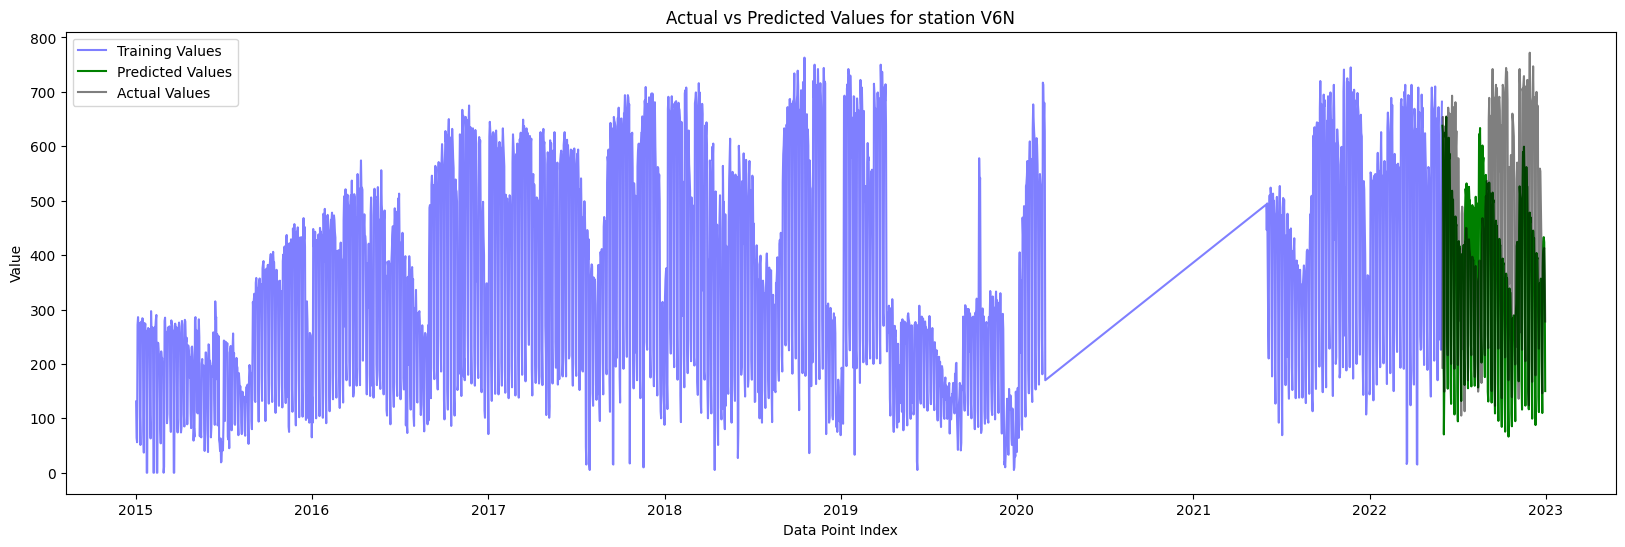

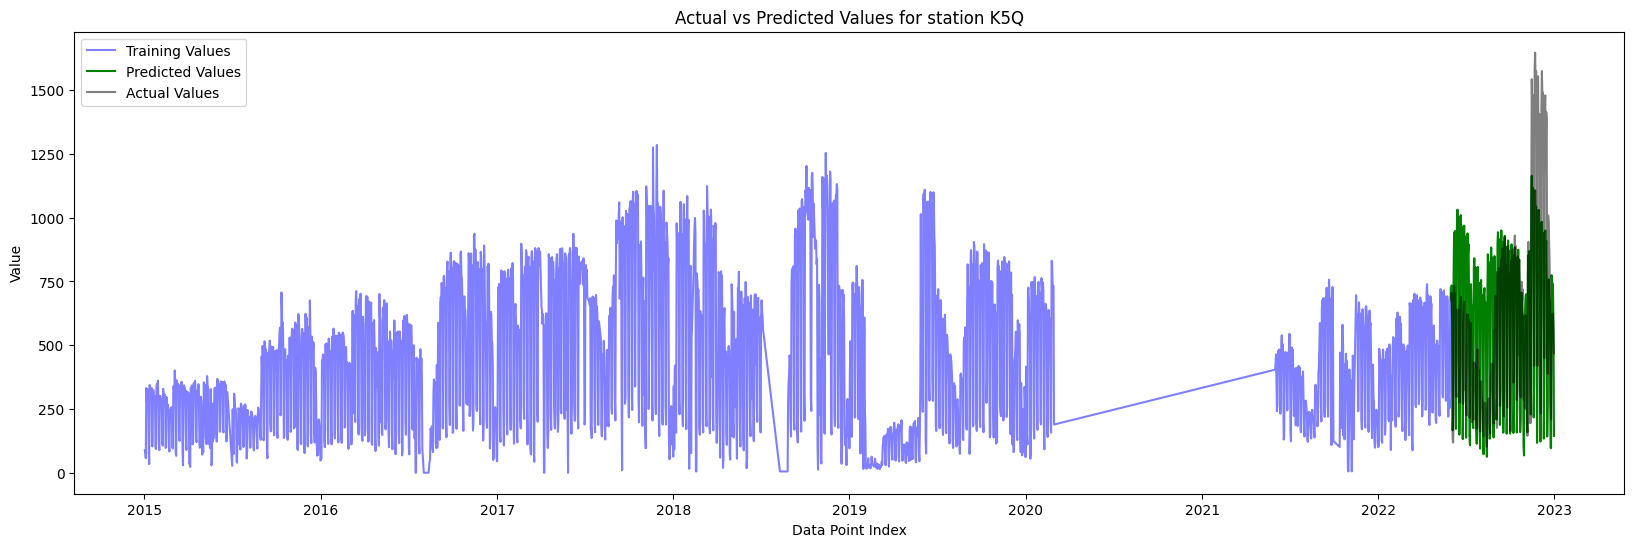

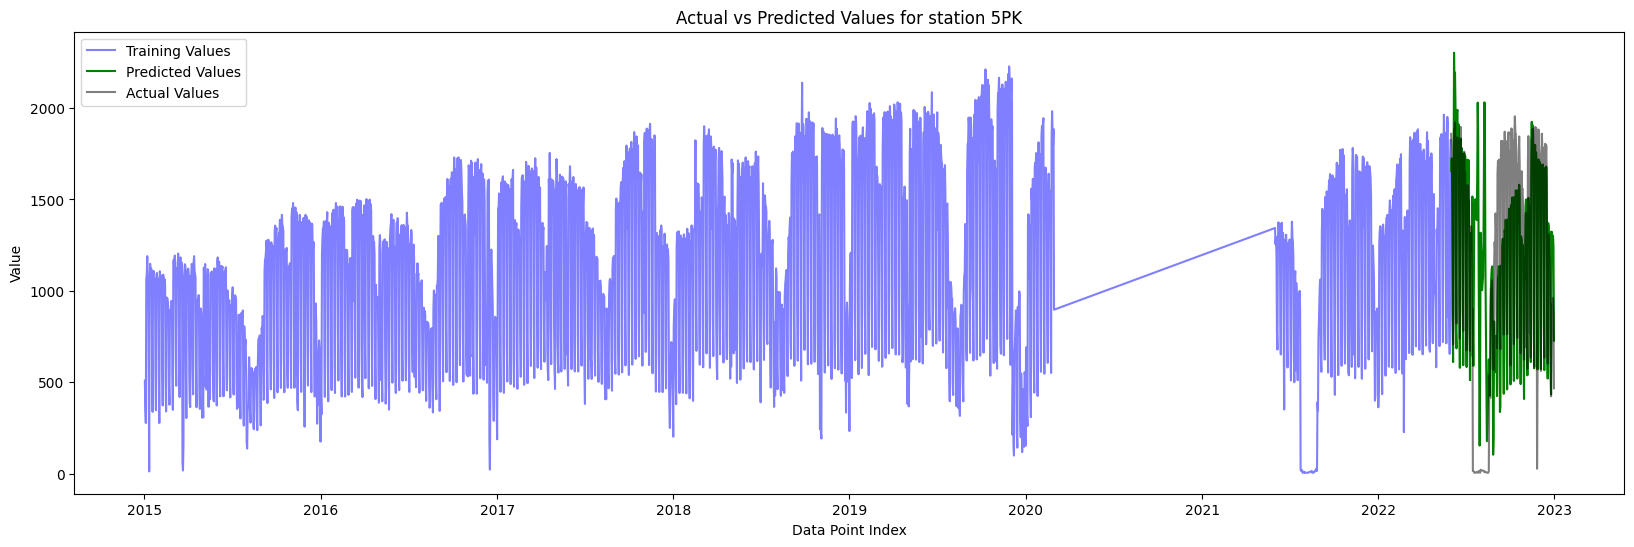

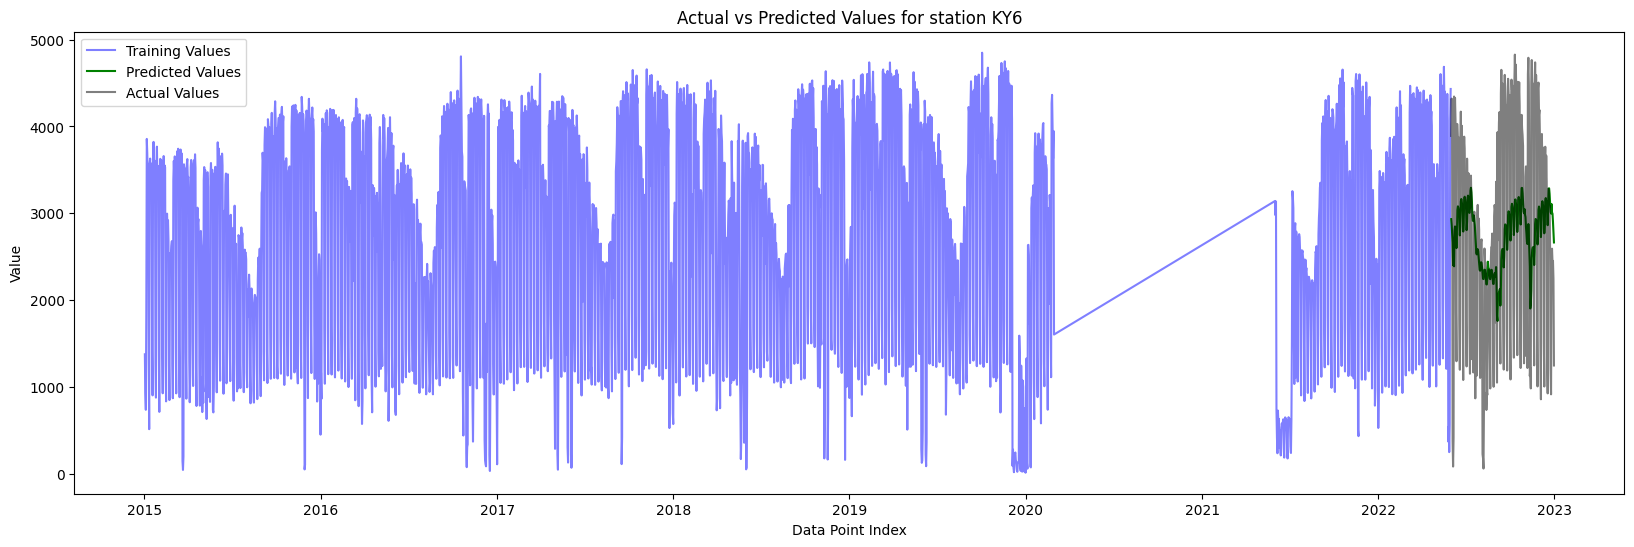

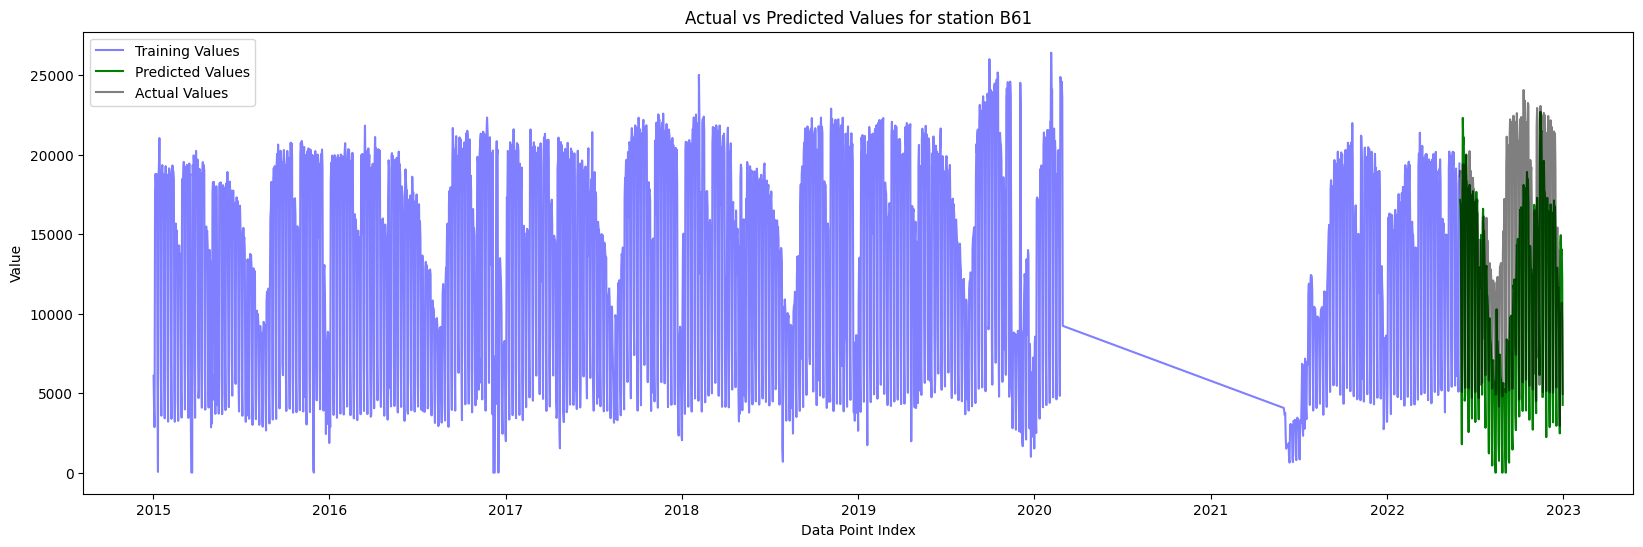

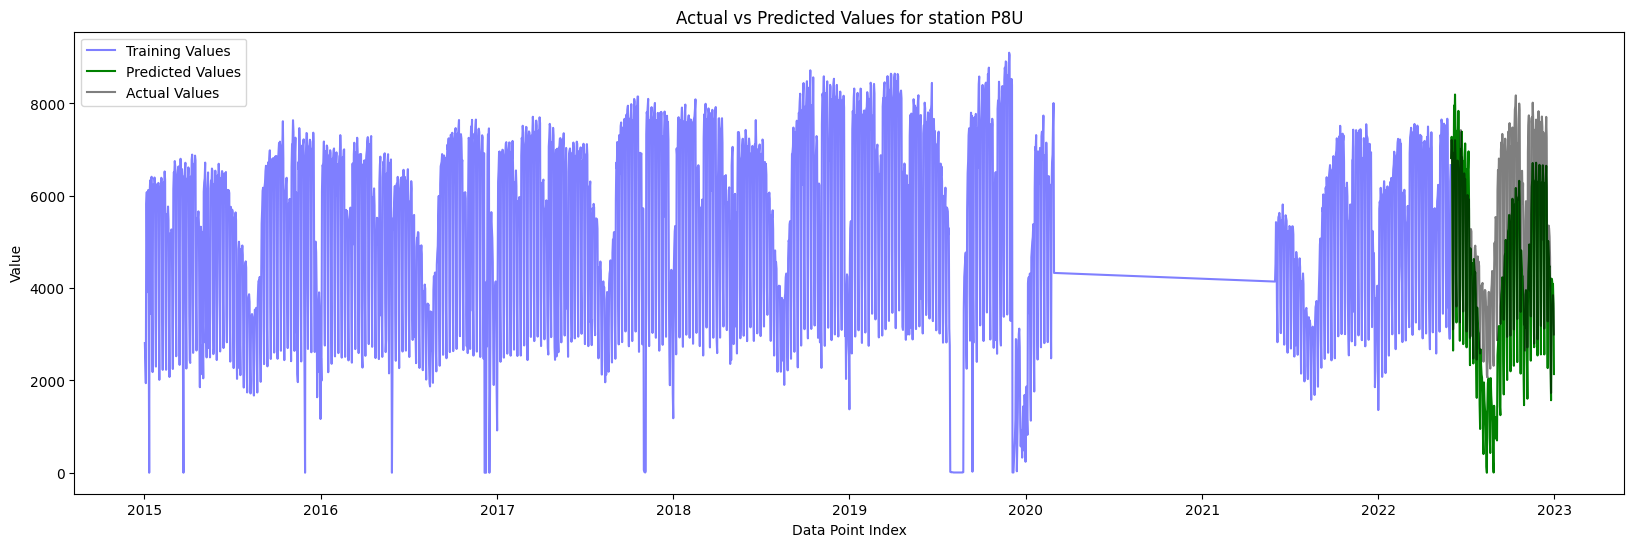

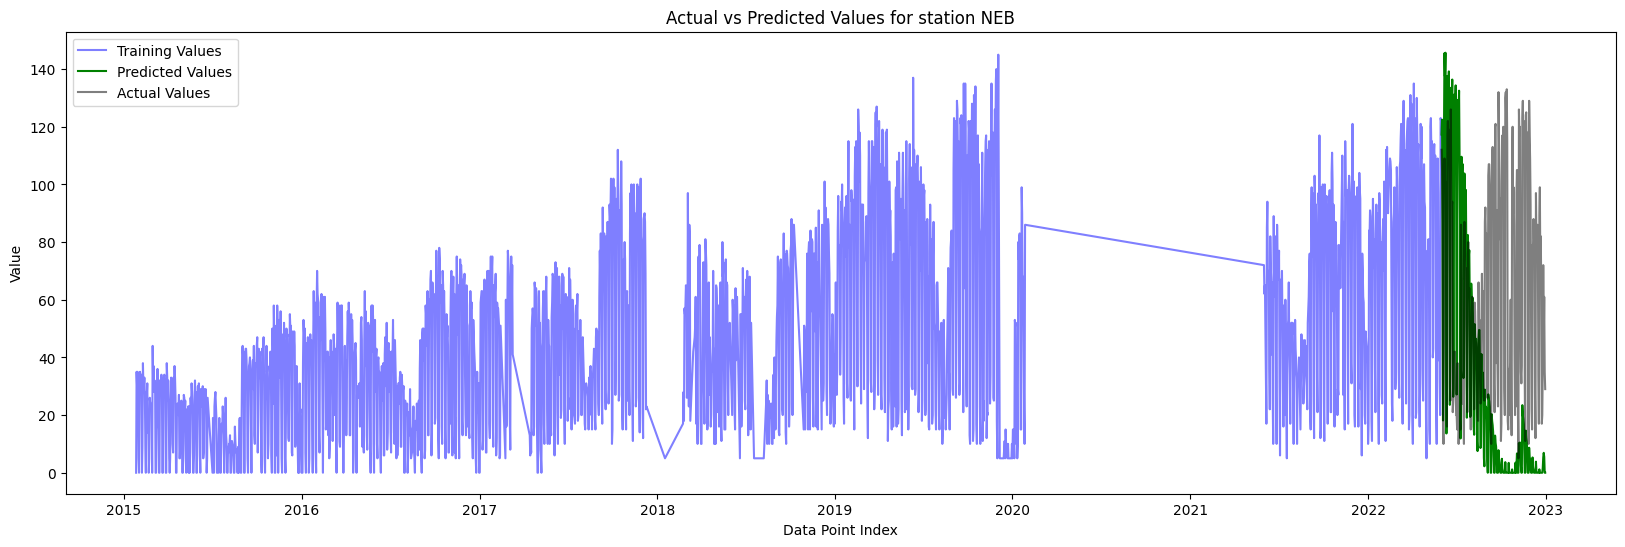

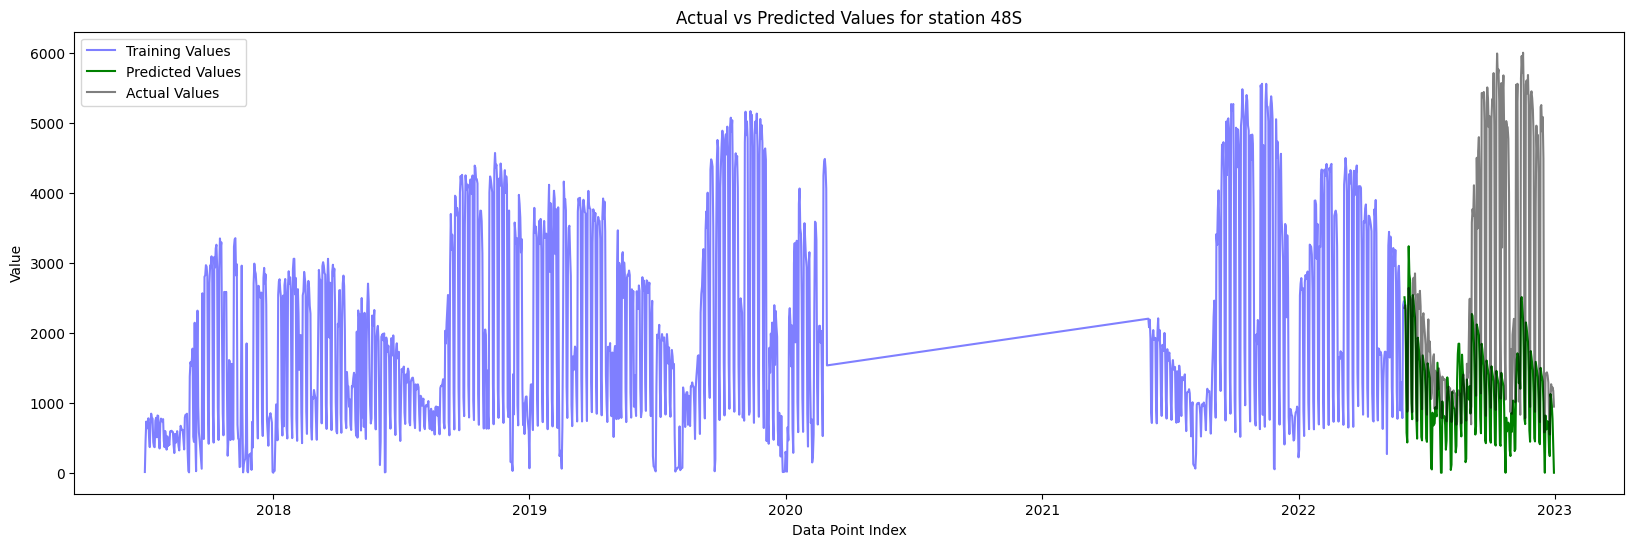

In [71]:
# Display predictions for the sample
for station in sample_test_AR.keys():
    utils.show_predictions_results_one_station(sample_train,
                            sample_test_AR,
                            sample_test_true,
                            station) 

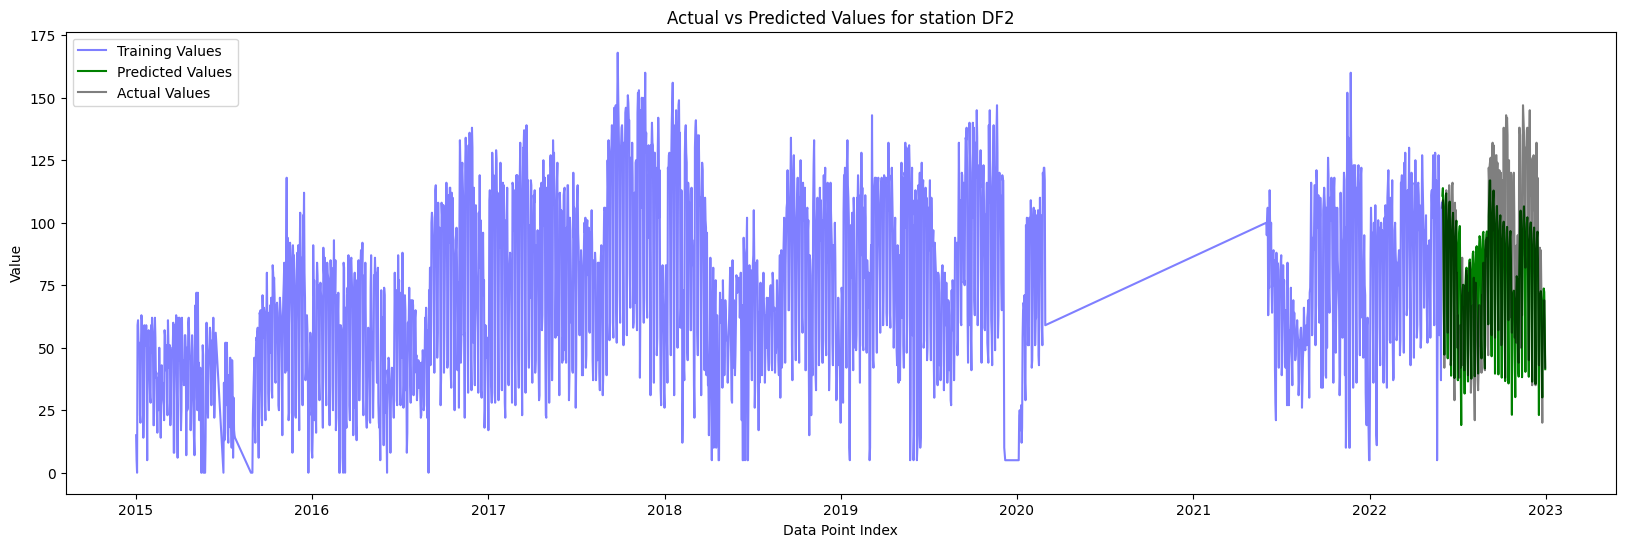

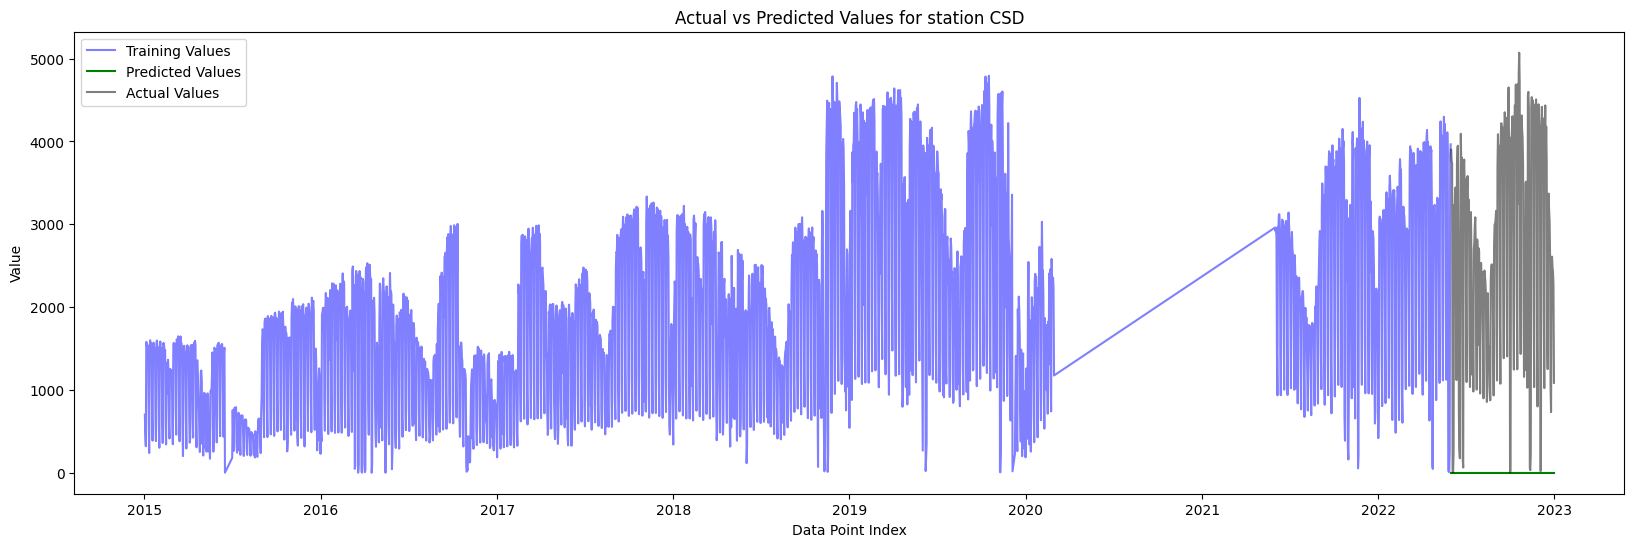

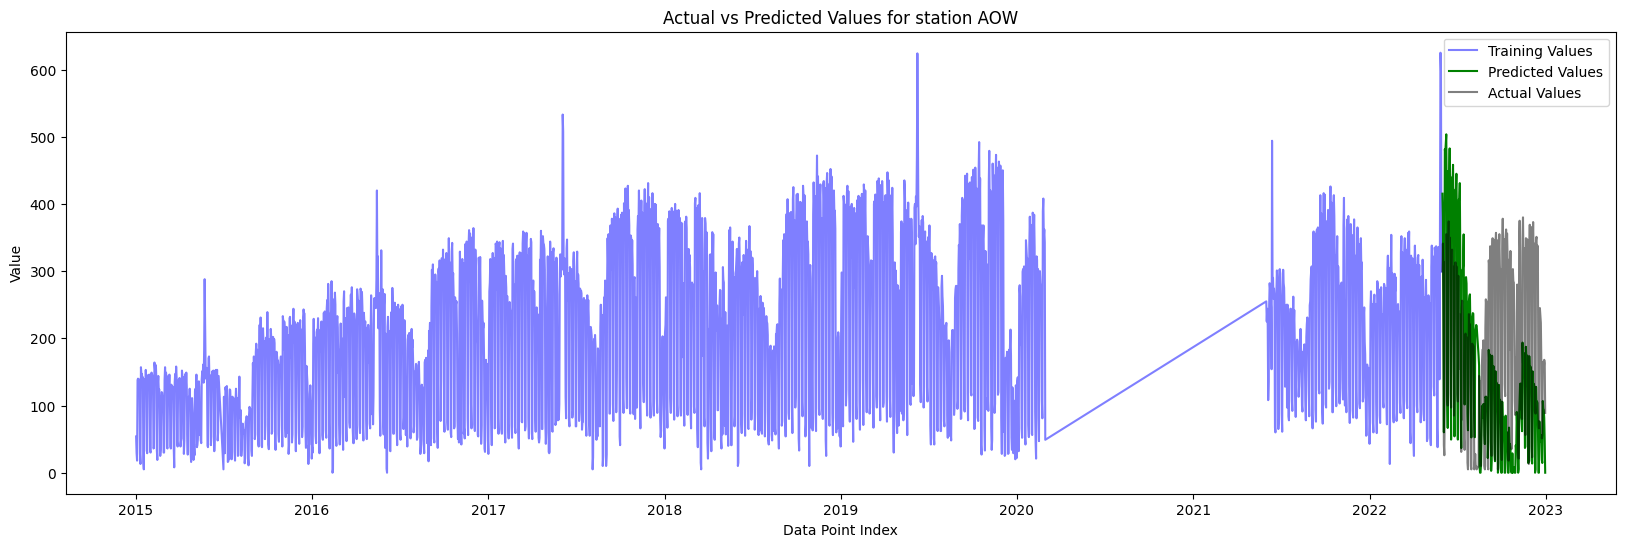

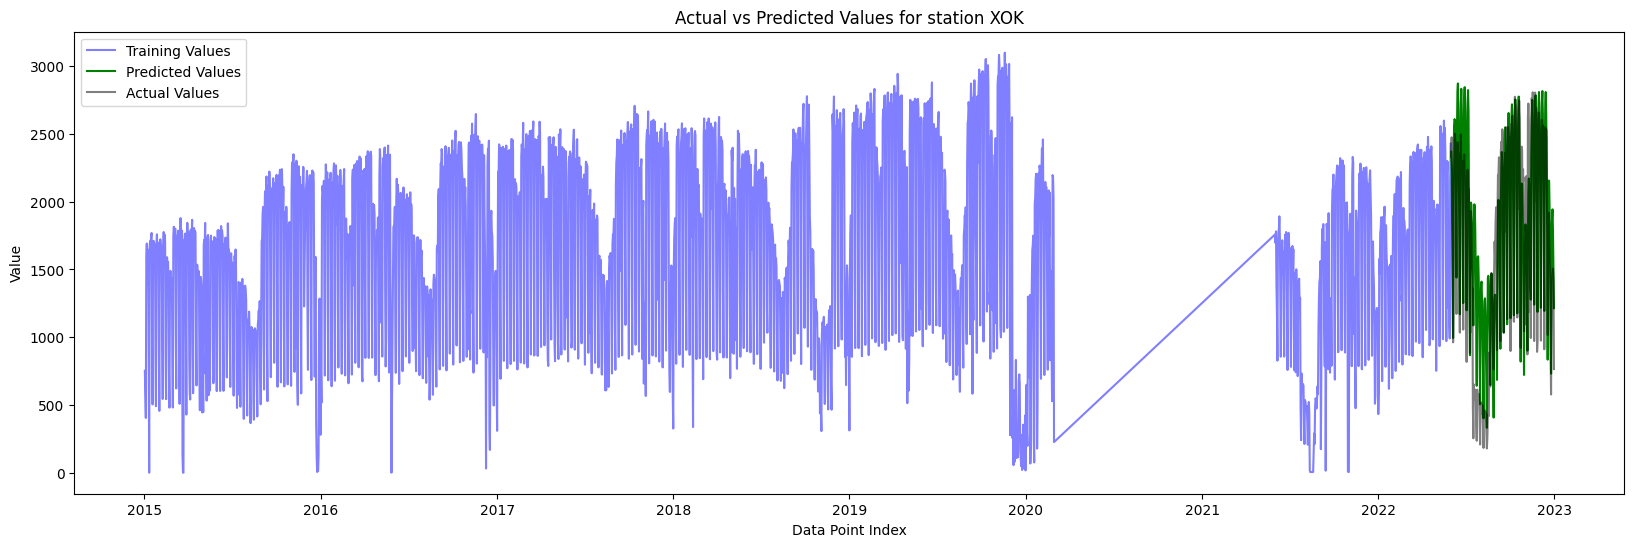

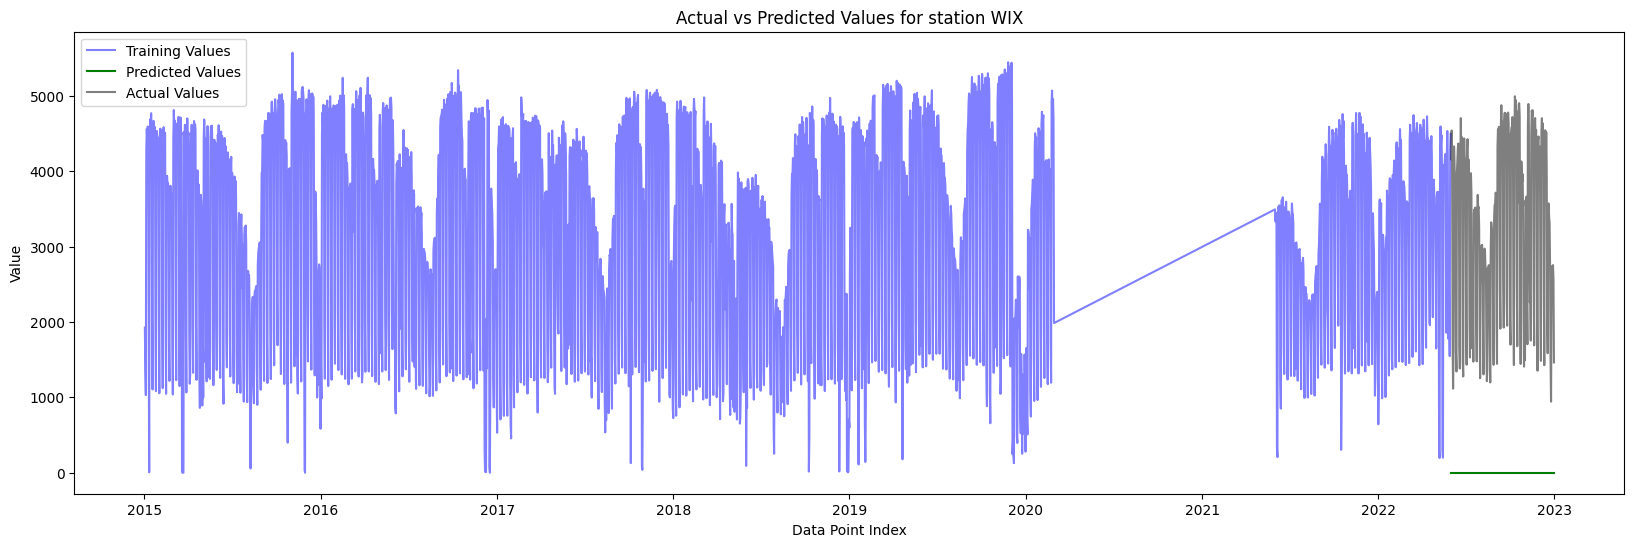

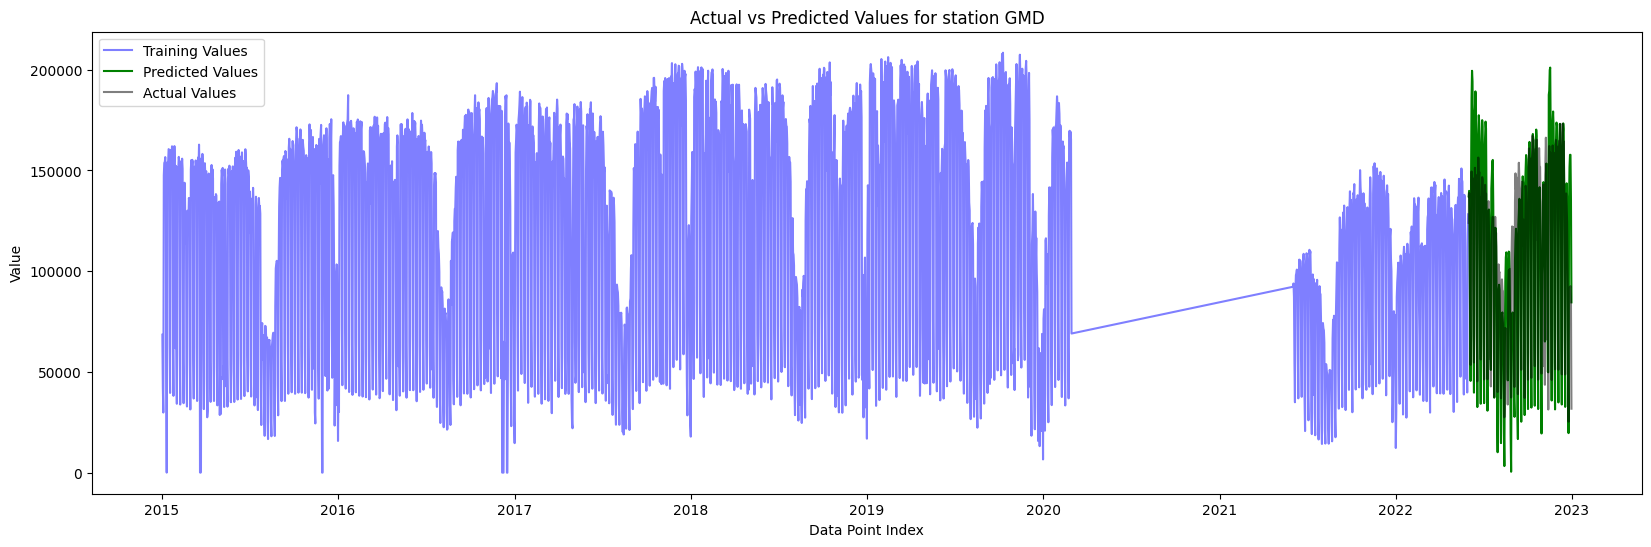

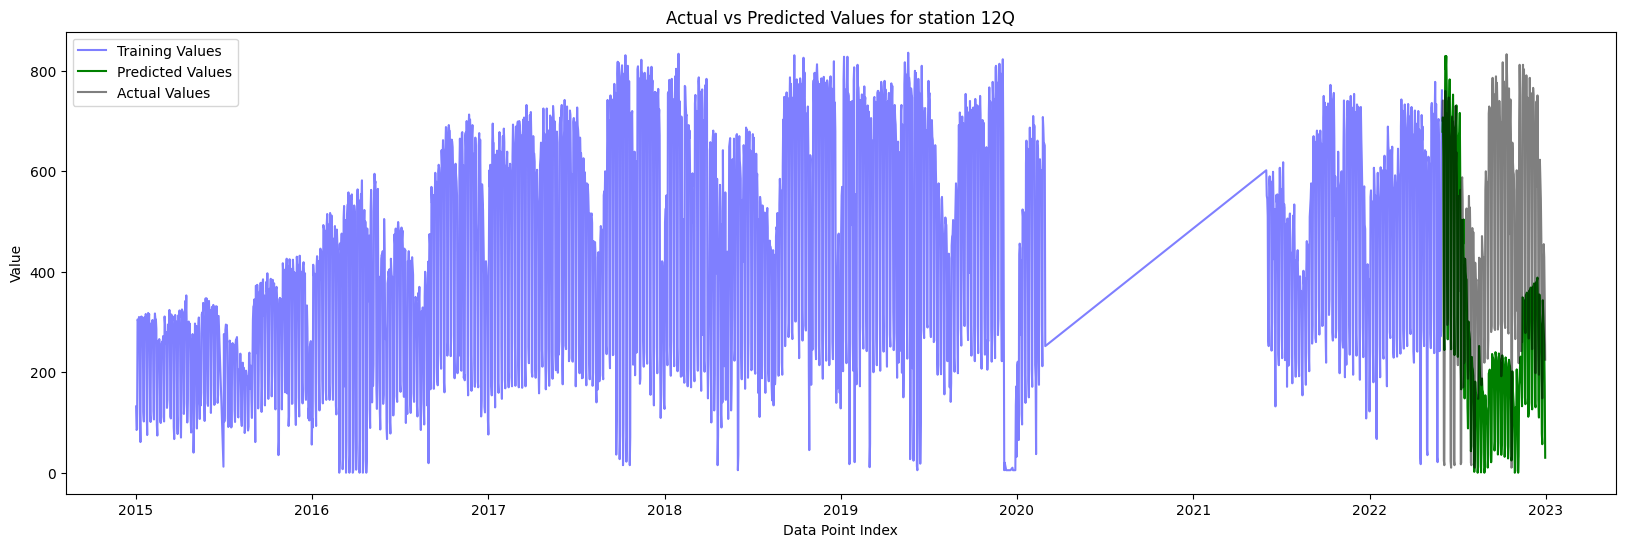

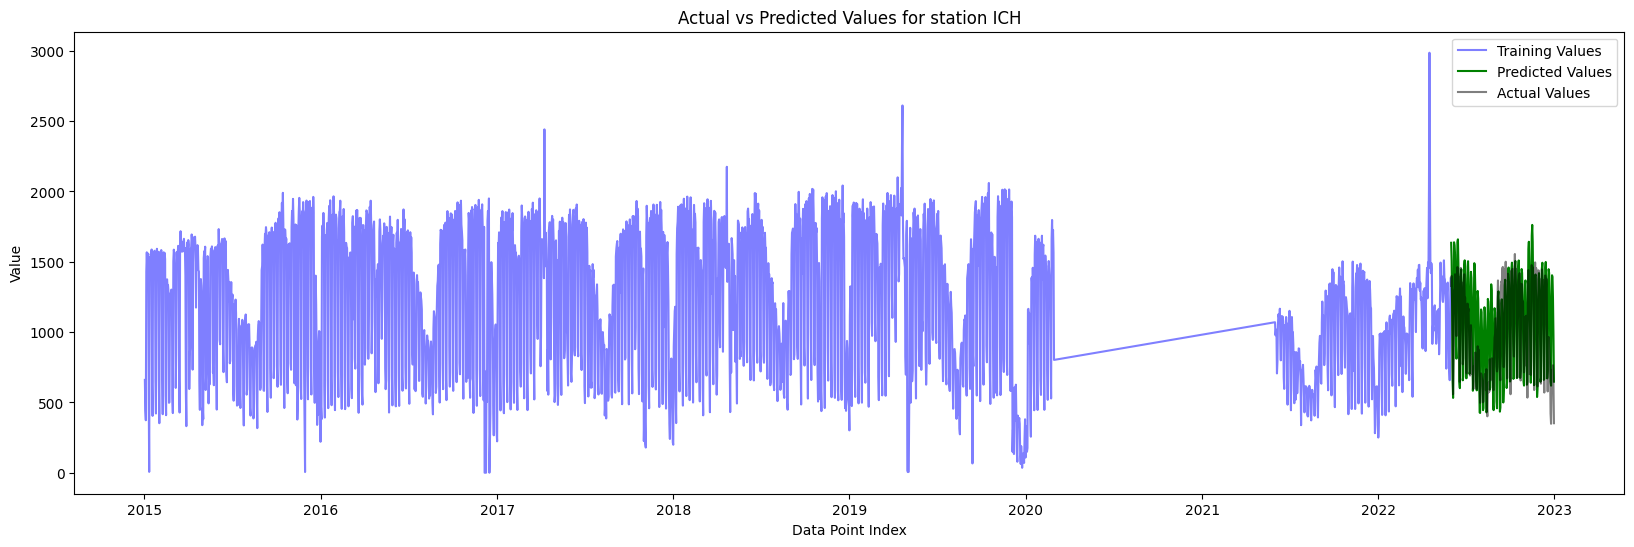

In [ ]:
# Display predictions for the sample
for station in sample_test.keys():
    utils.show_predictions_results_one_station(sample_train,
                            sample_test,
                            sample_test_true,
                            station) 

Il est très fréquent d'obtenir des valeurs négatives avec un LSTM autorégressif, même si l'affluence réelle ne peut pas l'être.
Pourquoi avez-vous des valeurs négatives ?

    L'absence de contrainte sur la sortie : Votre couche Dense(1) finale n'a pas de fonction d'activation. Elle peut donc prédire n'importe quel nombre réel dans l'intervalle (−∞,+∞).

    L'accumulation d'erreurs (Drift) : En mode autorégressif, si le modèle prédit une valeur légèrement plus basse que la réalité au jour 1, il utilise cette valeur pour prédire le jour 2. Si la tendance s'accentue, le modèle peut "plonger" sous zéro, surtout si la station a une faible affluence de base.

    Le Scaling : Le MinMaxScaler ramène vos données entre 0 et 1 pour l'entraînement, mais lors de l'inférence, rien n'empêche le modèle de sortir un chiffre comme -0.05 (scaled), qui deviendra une valeur négative après l'opération inverse_transform.